In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns

from tsfresh import extract_features
from tsfresh.utilities.dataframe_functions import make_forecasting_frame
from sklearn.ensemble import AdaBoostRegressor
from tsfresh.utilities.dataframe_functions import impute

import pandas_datareader.data as web
import datetime

import warnings
warnings.filterwarnings('ignore')

from tqdm import tqdm

/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# Collect the data for the google stock 

In [3]:
start = datetime.datetime(2016, 1, 1)
end = datetime.datetime(2017, 1, 1)
x = web.DataReader("F", 'google', start, end)
x.head()

,Open,High,Low,Close,Volume
Date,,,,,
2016-01-04,13.87,14.00,13.75,13.97,38525811
2016-01-05,13.97,14.00,13.51,13.72,50267536
2016-01-06,13.56,13.56,13.05,13.11,61285453
2016-01-07,12.90,13.04,12.60,12.70,57846688
2016-01-08,13.05,13.10,12.50,12.54,46199413


In [4]:
x.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 252 entries, 2016-01-04 to 2016-12-30
Data columns (total 5 columns):
Open      252 non-null float64
High      252 non-null float64
Low       252 non-null float64
Close     252 non-null float64
Volume    252 non-null int64
dtypes: float64(4), int64(1)
memory usage: 11.8 KB


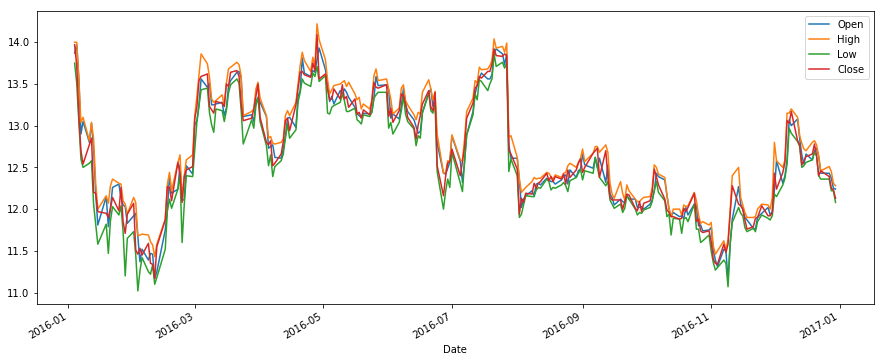

In [5]:
x.drop("Volume", axis=1).plot(figsize=(15, 6))
plt.show()

So, we loaded the google stock for one year. Now, we want to predict the High column.

# Create forecasting frame

In [6]:
df_shift, y = make_forecasting_frame(x["High"], kind="price", max_timeshift=20, rolling_direction=1)

In [7]:
df_shift.head()

,time,value,id,kind
4579,2016-01-04,14.0,2016-01-05,price
4329,2016-01-04,14.0,2016-01-06,price
4580,2016-01-05,14.0,2016-01-06,price
4080,2016-01-04,14.0,2016-01-07,price
4330,2016-01-05,14.0,2016-01-07,price


`df_shift` is ready to be passed into the feature extraction process in tsfresh 

In [8]:
X = extract_features(df_shift, column_id="id", column_sort="time", column_value="value", impute_function=impute,
                     show_warnings=False)

Feature Extraction: 100%|██████████| 10/10 [00:08<00:00,  1.24it/s]
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"rvalue"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"slope"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"stderr"'
 'value__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"intercept"'
 'value__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"rvalue"'
 'value__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"slope"'
 'value__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"stderr"'
 'value__agg_linear_trend__f_agg_"min"__chunk_len_50__attr_"intercept"'
 'value__agg_linear_trend__f_agg_"min"__chunk_len_50__attr_"rvalue"'
 'value__agg_linear_trend__f_agg_"min"__chunk_len_50__attr_"slope"'
 'value__agg_linear_trend__f_agg_"min"__chunk_len_50__attr_"stderr"'
 'value__agg_linear_trend__f_agg_"var"__chunk_len_50__attr_"intercept"'
 'value__agg_linear_trend__f_agg_"var"__chunk_len_50__attr_"rvalue"'
 'value__agg_linear_trend

In [9]:
# drop constant features
print(X.shape)
X = X.loc[:, X.apply(pd.Series.nunique) != 1] 
print(X.shape)

(251, 794)
(251, 347)


In [10]:
# Add last value as feature
X["feature_last_value"] = y.shift(1)

In [11]:
# Drop first line
X = X.iloc[1:, ]
y = y.iloc[1: ]

In [12]:
X.head()

variable,value__abs_energy,value__absolute_sum_of_changes,"value__agg_autocorrelation__f_agg_""mean""","value__agg_autocorrelation__f_agg_""median""","value__agg_autocorrelation__f_agg_""var""","value__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""intercept""","value__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""rvalue""","value__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""slope""","value__agg_linear_trend__f_agg_""max""__chunk_len_5__attr_""intercept""","value__agg_linear_trend__f_agg_""max""__chunk_len_5__attr_""rvalue""",...,value__symmetry_looking__r_0.75,value__symmetry_looking__r_0.8,value__symmetry_looking__r_0.8500000000000001,value__symmetry_looking__r_0.9,value__symmetry_looking__r_0.9500000000000001,value__time_reversal_asymmetry_statistic__lag_1,value__time_reversal_asymmetry_statistic__lag_2,value__time_reversal_asymmetry_statistic__lag_3,value__variance,feature_last_value
id,,,,,,,,,,,,,,,,,,,,,
2016-01-06,392.0000,0.00,0.000000,0.000000,0.000000,13.33,-1.0,-0.01,13.0015,-0.219347,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,14.00
2016-01-07,575.8736,0.44,-0.625000,-0.625000,0.140625,13.33,-1.0,-0.01,13.0015,-0.219347,...,1.0,1.0,1.0,1.0,1.0,-169.769600,0.000000,0.0,0.043022,13.56
2016-01-08,745.9152,0.96,-0.612853,-0.783749,0.483390,13.33,-1.0,-0.01,13.0015,-0.219347,...,1.0,1.0,1.0,1.0,1.0,-260.882752,0.000000,0.0,0.156300,13.04
2016-01-11,917.5252,1.02,-0.558454,-0.804121,0.562130,13.33,-1.0,-0.01,13.0015,-0.219347,...,1.0,1.0,1.0,1.0,1.0,-227.227616,-330.728400,0.0,0.173440,13.10
2016-01-12,1081.8776,1.30,-0.583313,-0.754310,0.672709,13.33,-1.0,-0.01,14.0000,-1.000000,...,1.0,1.0,1.0,1.0,1.0,-189.052842,-371.706552,0.0,0.216533,12.82


#  Fit Adaboost

In [13]:
ada = AdaBoostRegressor(n_estimators=10)
y_pred = [np.NaN] * len(y)

isp = 100   # index of where to start the predictions
assert isp > 0

for i in tqdm(range(isp, len(y))):
    
    ada.fit(X.iloc[:i], y[:i])
    y_pred[i] = ada.predict(X.iloc[i, :])[0]
    
y_pred = pd.Series(data=y_pred, index=y.index)

  0%|          | 0/150 [00:00<?, ?it/s]


ValueError: Expected 2D array, got 1D array instead:
array=[ 3.61823730e+03  1.80999994e+00  5.54540530e-02 -1.28874958e-01
  4.65516388e-01  1.37900000e+01 -1.00000000e+00 -1.09999999e-01
  1.36709995e+01 -3.56469721e-01 -4.89999987e-02  9.08129960e-02
  1.35179996e+01 -1.00000000e+00 -1.36999995e-01  1.35092001e+01
 -4.92334515e-01 -3.97999994e-02  4.97541949e-02  1.33800001e+01
 -1.00000000e+00 -1.80000007e-01  1.34340000e+01 -7.74596691e-01
 -8.10000002e-02  4.67653722e-02  1.06360000e-02  1.00000000e+00
  1.49729997e-02  8.32560007e-03  3.55100185e-01  4.21359995e-03
  7.84366857e-03  5.40672205e-02  3.28033864e-01  3.47771972e-01
  2.97154009e-01  3.15254480e-01  8.12188447e-01 -1.82468748e+00
  3.05431032e+00  6.28647685e-01  2.23368192e+00  4.26551878e-01
 -1.70886302e+00  8.00000000e+00  1.00000000e+00  5.88446081e-01
  1.70246825e-01 -1.99193899e-02 -1.74889594e-01 -2.18955576e-01
 -2.78834343e-01 -2.81099349e-01 -1.87605247e-01 -2.55108085e-02
  1.98999131e+00  2.42126929e+03  2.41673535e+03  2.41789526e+03
  3.33333351e-02 -1.33333337e-02 -1.99999996e-02  4.44444455e-03
  1.60000008e-02  3.50000001e-02 -5.71428565e-03 -4.00000019e-03
  1.49999997e-02  1.99999996e-02 -1.31578948e-02 -3.64285707e-02
 -2.33333334e-02 -7.00000003e-02 -7.99999982e-02  7.33333305e-02
  7.66666681e-02  5.00000007e-02  6.44444451e-02  4.39999998e-02
  3.50000001e-02  6.28571436e-02  5.20000011e-02  3.83333340e-02
  1.99999996e-02  9.52631608e-02  8.21428597e-02  7.66666681e-02
  1.19999997e-01  1.59999996e-01  4.62222239e-03  6.92222221e-03
  2.49999994e-03  5.31358039e-03  1.98399997e-03  2.24999996e-04
  5.38163260e-03  3.88400001e-03  1.62500003e-03  0.00000000e+00
  1.44742383e-02  9.49438754e-03  9.97777749e-03  1.61000006e-02
  2.55999994e-02  3.55555560e-04  1.22222223e-03  3.99999990e-04
  1.18024694e-03  3.03999986e-04  2.24999996e-04  1.46326527e-03
  1.19600003e-03  3.80555546e-04  0.00000000e+00  5.57229901e-03
  4.07397980e-03  4.64444421e-03  6.59999996e-03  6.39999984e-03
  5.27541459e-01  3.49259925e+00  1.10000000e+01  9.00000000e+00
  2.25243225e+01  2.13202447e-01  2.31463966e+01  7.15303278e+00
  4.46555672e+01  8.05390477e-02  4.60196381e+01  1.39047747e+01
  4.44025421e+01 -2.07566004e-02  4.41669426e+01  1.60900612e+01
  4.36780586e+01 -1.20144218e-01  4.21999893e+01  1.83424377e+01
  4.24548950e+01 -1.48443758e-01  4.01190720e+01  2.04007511e+01
  4.07299957e+01  1.48984075e-01  3.79084435e+01  2.19476700e+01
  2.62092361e+01  7.70228004e+00  2.57457905e+01  1.23169880e+01
  2.97773819e+01  1.02596340e+01  2.83146305e+01  1.68825417e+01
  3.31234398e+01  7.96967316e+00  3.08463326e+01  2.03485603e+01
  3.61517105e+01  4.26589441e+00  3.32997513e+01  2.24574986e+01
  3.87818985e+01  1.69906306e+00  3.56822166e+01  2.31254101e+01
  4.09537277e+01  5.88195741e-01  3.79614143e+01  2.25298615e+01
  4.26282692e+01  2.68509269e-01  4.01423798e+01  2.09525509e+01
  4.37945099e+01  1.99808419e-01  4.22386856e+01  1.87331371e+01
  4.44628296e+01  1.56529009e-01  4.42111740e+01  1.62706642e+01
  1.03300743e-01  9.93271768e-02  1.00590527e-01  1.01187944e-01
  1.00665398e-01  9.84403342e-02  9.73389968e-02  9.67508703e-02
  1.00007258e-01  1.02390744e-01  7.49387518e-02  6.23957138e+01
  7.42255878e+00  4.40332621e-01  2.68989990e+02  2.68989990e+02
  2.09999993e-01  0.00000000e+00  2.09999993e-01  1.31906939e+00
 -3.86621361e+01 -8.24057996e-01  1.02998662e+00  1.32214785e+00
  5.31918793e+01  1.05857301e+00  7.92147815e-01  5.32816589e-01
  6.68158264e+01  4.89788502e-01  2.09763527e-01  6.71062768e-02
  8.95241852e+01  6.71039596e-02  5.57280902e-04  3.84837627e-01
 -6.54328308e+01 -3.49999994e-01  1.59999996e-01  3.98904800e-01
 -4.58501320e+01 -2.86222309e-01  2.77852178e-01  5.75120747e-01
 -3.75892639e+01 -3.50821733e-01  4.55727965e-01  2.31725588e-01
  3.92515144e+01  1.46618754e-01  1.79442719e-01  2.69811958e-01
 -4.38667526e+01 -1.86975256e-01  1.94521829e-01  0.00000000e+00
  6.49999976e-01  2.25784180e+03 -5.19962219e+02  3.98685265e+01
 -1.02423322e+00  1.00000000e+00  0.00000000e+00  1.00000000e+00
  1.00000001e-01  2.00000003e-01  3.00000012e-01  4.00000006e-01
  6.00000024e-01  6.99999988e-01  8.50000024e-01  9.49999988e-01
 -1.34865716e-01  1.00000000e+00  1.00000000e+00  1.00000000e+00
  1.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.00000007e-02  8.00000012e-01
  2.00000000e+01  1.35211430e+01  2.18367815e-01 -2.87897080e-01
 -7.54135335e-03  5.91272581e-03  6.00000000e+00  7.00000000e+00
  1.37909079e+01  1.37900000e+01  1.34495001e+01  9.52631608e-02
 -1.31578948e-02  2.77777785e-03  1.34750004e+01  1.31999998e+01
  4.00000000e+00  2.00000000e+00  5.00000000e+00  1.00000000e+00
  1.00000000e+00  5.88446081e-01 -2.69257367e-01  1.87494699e-02
 -2.02467516e-01 -6.09011622e-03 -2.27757767e-01 -3.39879654e-02
 -5.42052202e-02  1.00100547e-01  2.50000000e-01  4.00000006e-01
  1.32539997e+01  1.33079996e+01  1.33680000e+01  1.34099998e+01
  1.35080004e+01  1.35260000e+01  1.35419998e+01  1.36079998e+01
  6.00000024e-01  2.50000000e-01  2.00000003e-01  5.00000007e-02
  0.00000000e+00  0.00000000e+00  8.00000012e-01  2.30258512e+00
  1.97695255e-01  1.02135822e-01  3.88294877e-03  1.29251927e-02
  1.51045516e-01  1.07279999e+02  5.36399994e+01  2.68989990e+02
  1.00000000e+00  1.00000000e+00  1.00000000e+00  1.00000000e+00
  1.00000000e+00  1.00000000e+00  1.00000000e+00  1.00000000e+00
  1.00000000e+00  1.00000000e+00  1.00000000e+00  1.00000000e+00
  1.00000000e+00  1.00000000e+00  1.00000000e+00  1.00000000e+00
  1.00000000e+00  1.00000000e+00  1.00000000e+00 -2.48084259e+00
 -6.92255080e-01 -1.43247194e+01  2.28147507e-02  1.35400000e+01].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [ ]:
plt.figure(figsize=(15, 8))
plt.plot(y, label="true")
plt.plot(y_pred, label="ada")
plt.legend()
plt.show()

Now, we will also inspect last value before the prediction as a benchmark tool, denoted by y-1

In [ ]:
plt.figure(figsize=(15, 8))
plt.plot(y, label="true")
plt.plot(y.shift(1), label="y-1")
plt.legend()
plt.show()

Looks not too bad. The green curve is the output of the AdaBoost Regressor, the blue curve is the true High value.

We can also inspect the relevance of the extracted features

In [ ]:
print("MAE y-1: \t{}".format(np.mean(np.abs(np.diff(y))[isp-1:] )))
print("MAE ada: \t{}".format(np.mean(np.abs(y_pred - y)[isp:])))

However, we are not yet beating the y-1 benchmark, so we need to invest more time into building dedicated features or use a better model.

In [ ]:
importances = pd.Series(index=X.columns, data=ada.feature_importances_)
importances.sort_values(ascending=False)

So, the minumum value "feature__maximum" during the last 10 values had the highest importance to predict the next value of the `High` column